In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm
import scipy.io as sio

# Sparse coding 

$$
\boldsymbol{I}(\boldsymbol{x}) = \sum_i r_i \phi_i (\boldsymbol{x}) + \epsilon(\boldsymbol{x})= \Phi \boldsymbol{r} + \epsilon(\boldsymbol{x})
\tag{1}
$$

$$
E = \underbrace{\left\|\boldsymbol{I}-\Phi \boldsymbol{r}\right\|^2}_{\text{preserve information}} + \lambda \underbrace{\sum_i S\left(\frac{r_i}{\sigma}\right)}_{\text{sparseness of}\ r_i} \tag{2}
$$

## What do we see in V1?

TODO: add empirical
TODO: add gabor

## Natural Images? 

In [7]:
!wget "http://www.rctn.org/bruno/sparsenet/IMAGES.mat"
!wget "http://www.rctn.org/bruno/sparsenet/IMAGES_RAW.mat"

--2021-04-17 16:45:43--  http://www.rctn.org/bruno/sparsenet/IMAGES.mat
Resolving www.rctn.org (www.rctn.org)... 208.113.160.104
Connecting to www.rctn.org (www.rctn.org)|208.113.160.104|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20971720 (20M)
Saving to: ‘IMAGES.mat.1’

IMAGES.mat.1        100%[===================>]  20.00M  36.1MB/s    in 0.6s    

2021-04-17 16:45:44 (36.1 MB/s) - ‘IMAGES.mat.1’ saved [20971720/20971720]

--2021-04-17 16:45:44--  http://www.rctn.org/bruno/sparsenet/IMAGES_RAW.mat
Resolving www.rctn.org (www.rctn.org)... 208.113.160.104
Connecting to www.rctn.org (www.rctn.org)|208.113.160.104|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20971720 (20M)
Saving to: ‘IMAGES_RAW.mat.1’

IMAGES_RAW.mat.1    100%[===================>]  20.00M  24.8MB/s    in 0.8s    

2021-04-17 16:45:45 (24.8 MB/s) - ‘IMAGES_RAW.mat.1’ saved [20971720/20971720]



In [8]:
# datasets from http://www.rctn.org/bruno/sparsenet/
mat_images = sio.loadmat('IMAGES.mat')
imgs = mat_images['IMAGES']
mat_images_raw = sio.loadmat('IMAGES_RAW.mat')
imgs_raw = mat_images_raw['IMAGESr']

In [9]:
# Plot datasets
N = 10 # number of images
c = 5 # number of columns
r = N // c # number of rows

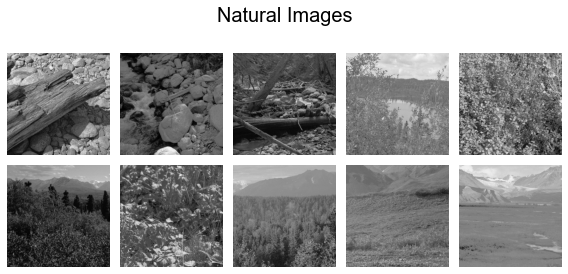

In [10]:
fig = plt.figure(figsize=(8, 2*r))
for i in range(N):
    plt.subplot(r, c, i+1)
    plt.imshow(imgs_raw[:,:,i], cmap="gray")
    plt.axis("off")
plt.tight_layout()
fig.suptitle("Natural Images", fontsize=20)
plt.subplots_adjust(top=0.9) 

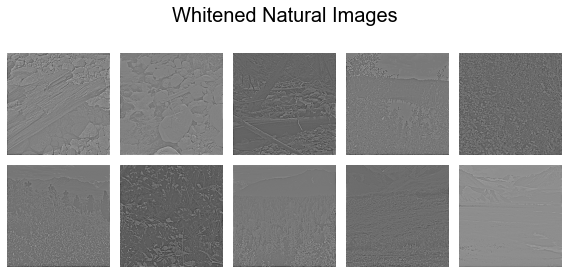

In [11]:
fig = plt.figure(figsize=(8, 2*r))
for i in range(N):
    plt.subplot(r, c, i+1)
    plt.imshow(imgs[:,:,i], cmap="gray")
    plt.axis("off")
plt.tight_layout()
fig.suptitle("Whitened Natural Images", fontsize=20)
plt.subplots_adjust(top=0.9) 

## Sparseness penalty 

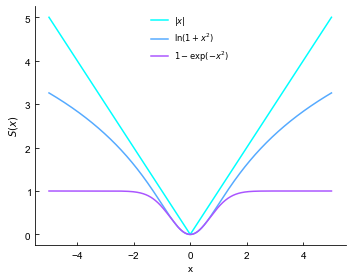

In [12]:
x = np.linspace(-5, 5, 1000)
color_map = cm.cool 

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(x, np.abs(x), label=r"$|x|$", color=color_map(0))
ax.plot(x, np.log(1+x**2), label=r"$\ln(1+x^2)$", color=color_map(.3333))
ax.plot(x, 1-np.exp(-x**2), label=r"$1-\exp(-x^2)$", color=color_map(.6666))

ax.set_xlabel("x")
ax.set_ylabel(r"$S(x)$")
ax.legend()
fig.tight_layout()

## Locally Competative Algorithm (LCA)

$$
\begin{aligned}
\frac{d \boldsymbol{r}}{dt} &= -\frac{\eta_\boldsymbol{r}}{2}\frac{\partial E}{\partial \boldsymbol{r}}\\
&=\eta_\boldsymbol{r} \cdot\left[\Phi^T (\boldsymbol{I}-\Phi\boldsymbol{r})- \frac{\lambda}{2\sigma}S'\left(\frac{r_i}{\sigma}\right)\right]
\end{aligned}\tag{3}
$$

In [17]:
class OlshausenField1996Model:
    def __init__(self, num_inputs, num_units, batch_size,
                    thresh_type="soft",
                    nt_max=1000, eps=1e-2,
                    lr_r=1e-2, lr_Phi=1e-2, lmda=5e-3):
        self.lr_r = lr_r # learning rate of r
        self.lr_Phi = lr_Phi # learning rate of Phi
        self.lmda = lmda # regularization parameter

        self.nt_max = nt_max # Maximum number of simulation time
        self.eps = eps  # small value which determines convergence
        
        self.num_inputs = num_inputs
        self.num_units = num_units
        self.batch_size = batch_size

        assert thresh_type in ["soft", "ln"]
        self.thresh_type = thresh_type
        if self.thresh_type == "soft":
            self._spasity_func = lambda x: np.abs(x)
            self._thresh_func = self.soft_thresholding_func
        elif self.thesh_type == "ln":
            self._spasity_func = lambda x: np.ln(1 + x**2)
            self._thresh_func = self.ln_thresholding_func
        elif self.thesh_type == "cauchy":
            self._spasity_func = lambda x: np.abs(x)
            self._thresh_func = self.cauchy_thresholding_func

        # Weights
        Phi = np.random.randn(self.num_inputs, self.num_units).astype(np.float32)
        self.Phi = Phi * np.sqrt(1/self.num_units)

        # activity of neurons
        self.r = np.zeros((self.batch_size, self.num_units))
    
    def initialize_states(self):
        self.r = np.zeros((self.batch_size, self.num_units))
        
    def normalize_rows(self):
        self.Phi = self.Phi / np.maximum(np.linalg.norm(self.Phi, ord=2, axis=0, keepdims=True), 1e-8)

    # thresholding function of S(x)=|x|
    def soft_thresholding_func(self, x, lmda):
        return np.maximum(x - lmda, 0) - np.maximum(-x - lmda, 0)

    # thresholding function of S(x)=ln(1+x^2)
    def ln_thresholding_func(self, x, lmda):
        f = 9*lmda*x - 2*np.power(x, 3) - 18*x
        g = 3*lmda - np.square(x) + 3
        h = np.cbrt(np.sqrt(np.square(f) + 4*np.power(g, 3)) + f)
        two_croot = np.cbrt(2) # cubic root of two
        return (1/3)*(x - h / two_croot + two_croot*g / (1e-8+h))

    # thresholding function https://arxiv.org/abs/2003.12507
    def cauchy_thresholding_func(self, x, lmda):
        f = 0.5*(x + np.sqrt(np.maximum(x**2 - lmda,0)))
        g = 0.5*(x - np.sqrt(np.maximum(x**2 - lmda,0)))
        return f*(x>=lmda) + g*(x<=-lmda) 

    def calculate_error(self, inputs):
        error = inputs - self.r @ self.Phi.T
        return(error)

    def calculate_total_error(self, error):
        recon_error = np.mean(error**2)
        sparsity_r = self.lmda*np.mean(self._spasity_func(self.r)) 
        return(recon_error + sparsity_r)

    def update_r(self, inputs):
        error = self.calculate_error(inputs)
        r = self.r + self.lr_r * error @ self.Phi
        self.r = self._thresh_func(r, self.lmda)
        return(error)

    def update_Phi(self, inputs):
        error = self.calculate_error(inputs)
        dPhi = error.T @ self.r
        self.Phi += self.lr_Phi * dPhi
        return(error)
    
    def train(self, inputs):
        self.initialize_states() # Reset states
        self.normalize_rows() # Normalize weights
        
        # Input an image patch until latent variables are converged 
        r_tm1 = self.r # set previous r (t minus 1)
        for t in range(self.nt_max):
            # Update r without updating weights 
            error = self.update_r(inputs)
            dr = self.r - r_tm1 

            # Compute norm of r
            dr_norm = np.linalg.norm(dr, ord=2) / (self.eps + np.linalg.norm(r_tm1, ord=2))
            r_tm1 = self.r # update r_tm1
            
            # Check convergence of r, then update weights
            if dr_norm < self.eps:
                error = self.update_r(inputs)
                error = self.update_Phi(inputs)
                break
            
            # If failure to convergence, break and print error
            if t >= self.nt_max-2: 
                print("Error at patch:", iter_)
                print(dr_norm)
                break
        return(error)

In [18]:
def generate_patches(input_images, patch_size, batch_size):
    H, W, num_images = input_images.shape
    
    # Set the coordinates of the upper left corner of random image sz X sz image clips
    x0 = np.random.randint(0, W-patch_size, batch_size)
    y0 = np.random.randint(0, H-patch_size, batch_size)

    # Generating inputs
    patches_list = []
    for i in range(batch_size):        
        idx = np.random.randint(0, num_images)
        img = input_images[:, :, idx]
        clip = img[y0[i]:y0[i]+patch_size, x0[i]:x0[i]+patch_size].flatten()
        patches_list.append(clip - np.mean(clip))
        
    patches = np.array(patches_list) # Input image patches
    return(patches)

In [19]:
# Simulation constants
num_units = 100 # number of neurons (units)
patch_size = 16 # image patch size

num_iter = 500 # number of iterations
batch_size = 250 # Batch size

# Define model
model = OlshausenField1996Model(num_inputs=patch_size**2, 
                                num_units=num_units,
                                batch_size=batch_size)

In [20]:
# Run simulation
error_list = [] # List to save errors
for iter_ in tqdm(range(num_iter)):
    patches = generate_patches(imgs, patch_size, batch_size) # Generating image patches
    error = model.train(patches) # train model with patches 

    error_list.append(model.calculate_total_error(error))
    # Print moving average error
    if iter_ % 100 == 99:  
        print("iter: "+str(iter_+1)+"/"+str(num_iter)+", Moving error:",
              np.mean(error_list[iter_-99:iter_]))

iter: 100/500, Moving error: 0.05367018500789625
iter: 200/500, Moving error: 0.049567153558238736
iter: 300/500, Moving error: 0.04930455748142387
iter: 400/500, Moving error: 0.0482781656737577
iter: 500/500, Moving error: 0.048408860697580096



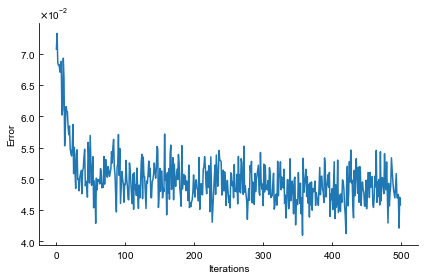

In [21]:
# Plot error
plt.figure(figsize=(6, 4))
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.plot(np.arange(len(error_list)), np.array(error_list))
plt.tight_layout()
plt.show()

In [22]:
def plot_receptive_fields(fields, c=10, title="Receptive Fields"):
    num_units, num_inputs = fields.shape
    patch_size = int(np.sqrt(num_inputs))
    r = num_units // c

    fig = plt.figure(figsize=(6, .6*r))
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in tqdm(range(num_units)):
        plt.subplot(r, c, i+1)
        plt.imshow(np.reshape(fields[i], (patch_size, patch_size)), cmap="gray")
        plt.axis("off")

    fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.9)

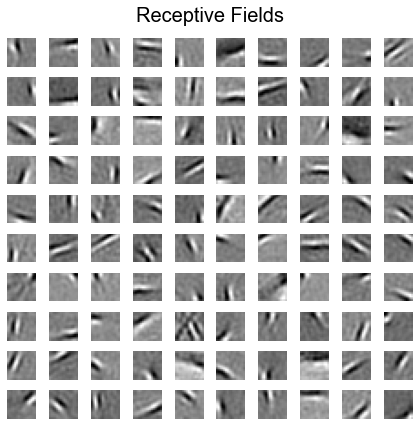

In [23]:
plot_receptive_fields(model.Phi.T)

## What else could we compare it to?

In [24]:
from sklearn.decomposition import FastICA, PCA
patches = generate_patches(imgs, patch_size, num_iter*batch_size)

### PCA

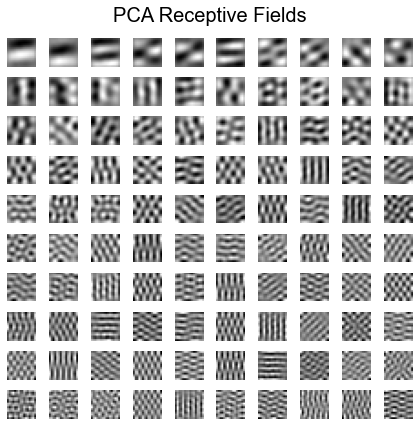

In [25]:
# perform PCA
pca = PCA(n_components=num_units)
pca.fit(patches)
pca_filters = pca.components_

plot_receptive_fields(pca_filters, title="PCA Receptive Fields")

### ICA

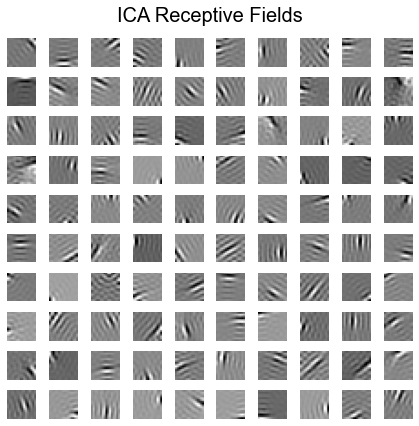

In [26]:
# perform ICA
ica = FastICA(n_components=num_units)
ica.fit(patches)
ica_filters = ica.components_

plot_receptive_fields(ica_filters, title="ICA Receptive Fields")
